In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusers import UNet2DConditionModel

In [4]:
!pip install huggingface-hub==0.25.2

  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.3
    Uninstalling huggingface-hub-0.26.3:
      Successfully uninstalled huggingface-hub-0.26.3


In [2]:
unet=UNet2DConditionModel.from_pretrained('',subfolder="unet",residual=None)
t=10
input=10
masked_features=100
encoder_hidden_states=199
feature_masks=100
segmentation_masks=100
noisy_residual = unet(input, t, encoder_hidden_states, masked_feature=masked_features, feature_mask=feature_masks[:16], segmentation_mask=segmentation_masks).sample

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like  is not the path to a directory containing a file named diffusion_pytorch_model.bin or 
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/diffusers/installation#offline-mode'.

## Model

In [11]:
from diffusers import UNet2DModel  

repo_id='google/ddpm-cat-256'
model=UNet2DModel.from_pretrained(repo_id,use_safetensors=True)

In [12]:
model.config #to access the model parameters

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('time_embedding_dim', None),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('

In [13]:
torch.manual_seed(0)

noisy_sample=torch.randn(1,model.config.in_channels,model.config.sample_size,model.config.sample_size)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


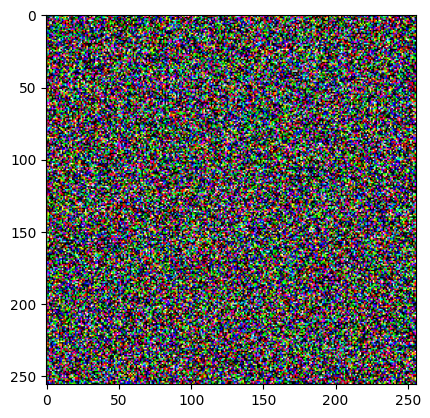

In [14]:
image=noisy_sample.squeeze(0) #to remove the batch dimension
plt.imshow(image.permute(1,2,0))

In [15]:
with torch.no_grad(): #disable gradient calculation
    noisy_residual=model(sample=noisy_sample,timestep=2).sample  #it predicts how noisy a image is at timestep . It helps the model to determine its position in the diffusion process

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


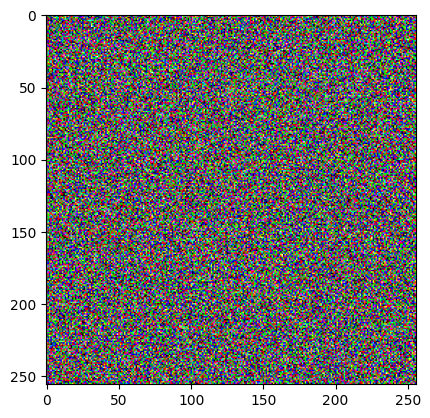

In [16]:
image=noisy_residual.squeeze(0) #to remove the batch dimension
plt.imshow(image.permute(1,2,0))

#to generate actual examples though, you need a schedular to guide the denoising process 

## Schedular
use to guide the denoising process (schedular(xt,pred_e,timestep) => xt-1)

In [17]:
from diffusers import DDPMScheduler

schedular=DDPMScheduler.from_pretrained(repo_id)
schedular
## unlike a model, a schedular does not have trainable weight and is parameter free


DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.32.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

- num_train_timestep: the length of the denoising process, or in other words the number of timesteps required to process random Gaussian noise into a data sample
- beta_schedule: the type of noise schedule used for inference and training
- beta_start and beta_end: the start and end noise value for the noise schedule

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])


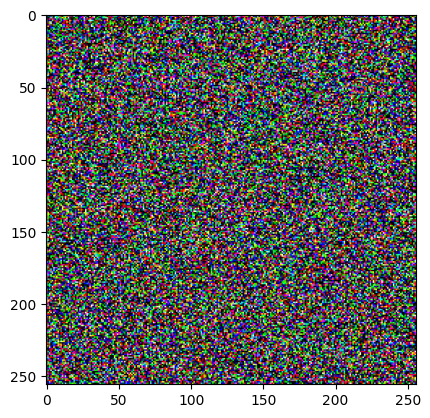

In [18]:
# helps approximate the reverse diffusion process to reach the original image
less_noisy_sample=schedular.step(model_output=noisy_residual,timestep=2,sample=noisy_sample).prev_sample  #gives the denoised sample at the next timestep in reverse diffusion process
print(less_noisy_sample.shape)

image=less_noisy_sample.squeeze(0) #to remove the batch dimension


plt.imshow(image.permute(1,2,0))

In [19]:
import PIL.Image

def display_sample(sample,i):
    image_processed=sample.cpu().permute(0,2,3,1)
    image_processed=(image_processed+1.0)*127.5
    image_processed=image_processed.numpy().astype(np.uint8)

    image_pil=PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [20]:
#  to speed up the denoising process and move the input and model to GPU

model.to("cuda")
noisy_sample=noisy_sample.to("cuda")

In [21]:
print(schedular.timesteps)

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

In [ ]:
import tqdm


sample=noisy_sample

for i,t in enumerate(tqdm.tqdm(schedular.timesteps)):
    with torch.no_grad():
        residual=model(sample,t).sample

    sample=schedular.step(residual,t,sample).prev_sample

    if (i+1)%100==0:
        display_sample(sample,i+1)

## Effective and efficient diffusion

In [3]:
from diffusers import DiffusionPipeline
import torch

model_id="stable-diffusion-v1-5/stable-diffusion-v1-5"
pipeline=DiffusionPipeline.from_pretrained(model_id,use_safetensors=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
# place the pipeline on gpu
pipeline=pipeline.to('cuda')

OutOfMemoryError: CUDA out of memory. Tried to allocate 114.00 MiB. GPU 

In [9]:
prompt="potrait photo of old warrior chief"

generator=torch.Generator("cpu").manual_seed(0)  #so that we can make use of the same image and improve on it we use generator and set a seed for reporducibility
# creates adn returns a generator object that manages the state of the algorithm which produce pseudo random numbers

image=pipeline(prompt,generator=generator).images[0]




  0%|          | 0/50 [00:00<?, ?it/s]

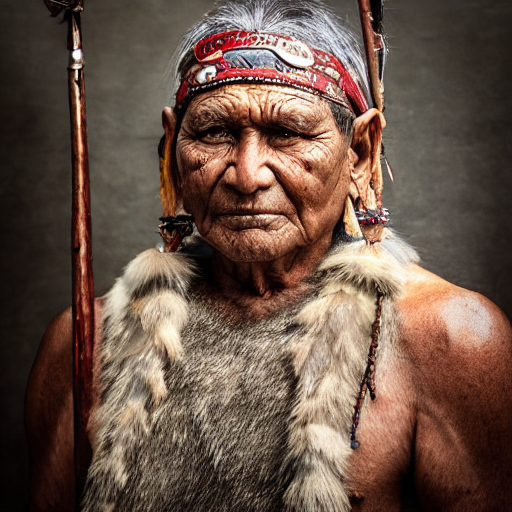

In [10]:
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/adi_techbuddy/anaconda3/envs/torchenv/lib/python3.8/site-packages/diffusers/image_processor.py:147: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


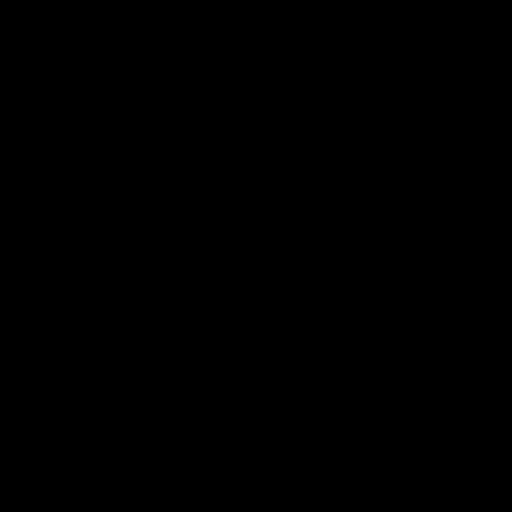

In [11]:
# using a lower precision

pipeline=DiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float16,use_safetensors=True)
pipeline=pipeline.to("cuda")
generator=torch.Generator("cuda").manual_seed(0)
image=pipeline(prompt,genrator=generator).images[0]
image